# Machine Vision<br>Assignment 6 - Motion


## 1. Background subtraction

In this assignment we use background subtraction techniques to detect objects of interest in a video. We use a dynamic background that is continuously updated and threshold every frame of the video to detect new objects.

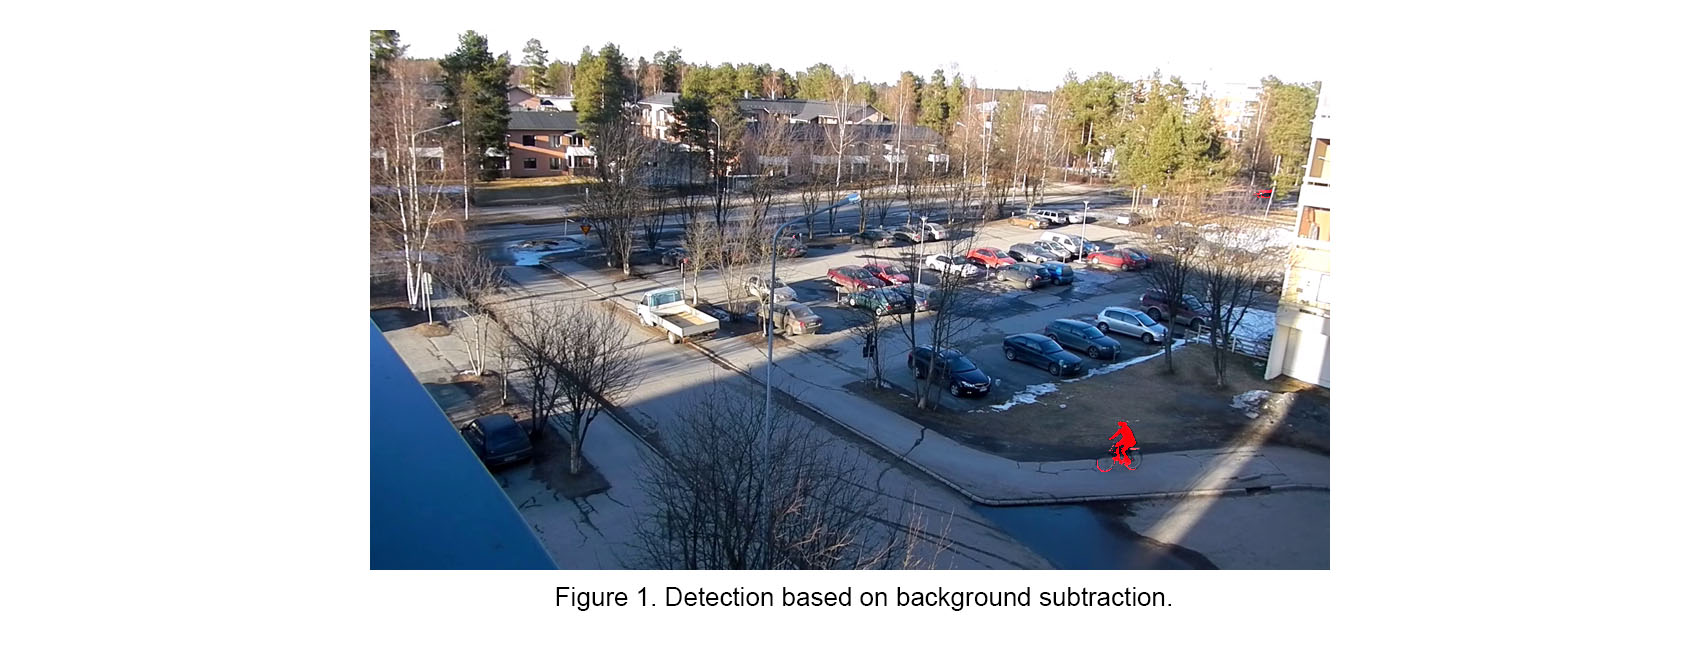

**1.1. Introduction**

We will implement object detection through background subtraction as described in the lecture notes. We work with grayscale images. The background is a dynamic model where each pixel is described by a Gaussain (i.e. mean and variance). The background model for each pixel is updated after each frame according to the equations:

$$
\mu_{t+1} = \alpha \mu_t + (1-\alpha) z_{t+1} \qquad \qquad \qquad \qquad \qquad \qquad (1) \\
\sigma_{t+1}^2 = \alpha [\sigma_t^2 + (\mu_{t+1} - \mu_t)^2] + (1-\alpha)(z_{t+1} - \mu_{t+1})^2 \qquad \ \   (2)
$$

where $\alpha$ controls the rate of adaptation $(0 < \alpha < 1)$ and $z_t$ is the observed pixel value at time $t$. With this model we can decide whether a pixel contains an object of interest with the formula

$$
| z_t - \mu_t | > 3 \, \text{max}(\sigma_t, \sigma_{rcam}) \qquad \qquad (3)
$$

where $\sigma_{rcam}$ represents the standard deviation of the camera noise. We first extact the first two frames from a video and estimate $\sigma_{rcam}$.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read first two frames
cap = cv2.VideoCapture('test.mp4')
ret, color1 = cap.read()
ret, color2 = cap.read()
cap.release()

# We work with grayscale images (range [0,1])
frame1 = cv2.cvtColor(color1, cv2.COLOR_BGR2GRAY)/255
frame2 = cv2.cvtColor(color2, cv2.COLOR_BGR2GRAY)/255

# Estimate camera noise
diff = frame1.ravel() - frame2.ravel()
sigma_cam = np.std(diff)

# Video compression algorithms may distort the noise distribution.
# Enforce a minimum.
sigma_cam = np.max([sigma_cam, 1/255])
print('Camera noise (std): %.4f' %(sigma_cam*255))

Camera noise (std): 1.0000


Next we initialize the model.

In [2]:
# Initialize mean and variance images
mean_img = frame1
var_img = sigma_cam * np.ones_like(frame1)

# The current state is stored in a dictionary
state_initial = {"alpha": 0.99,
                 "sigma_cam": sigma_cam,
                 "mean_img": mean_img,
                 "var_img": var_img}

# You can access the values by
alpha = state_initial["alpha"] # Or: state.get("alpha")

# And you can change the values by
state_initial["alpha"] = 0.98

**1.2. Update background model** $\quad$ <font color=red>(1.00 points)</font>

Complete the following code cell. The function `updateBackgroundModel` should update the dynamic background based on the previous model. Specifically, you need to update the current mean background image `state["mean_img"]` and the variance of the background `state["var_img"]` using Eq. (1) and Eq. (2).

In [3]:
# INPUT   
# frame : The current grayscale image
# state : The current state (as define above)
#
# OUTPUT  
# state : Updated state, where state["mean_img"] and
#         state["var_img"] have been updated.
#
def updateBackgroundModel(frame, state):
    
    # ---------- YOUR CODE STARTS HERE -----------
    alpha = state["alpha"]
    mean_img = state["mean_img"]
    var_img = state["var_img"]
    
    #𝜇𝑡+1=𝛼𝜇𝑡+(1−𝛼)𝑧𝑡+1
    
    mean_img_update = alpha * mean_img + (1 - alpha) * frame
    
    mean_diff = mean_img_update - mean_img
    
    #𝜎2𝑡+1=𝛼[𝜎2𝑡+(𝜇𝑡+1−𝜇𝑡)2]+(1−𝛼)(𝑧𝑡+1−𝜇𝑡+1)2
    var_img_update = alpha * (var_img + mean_diff**2) + (1 - alpha) * (frame - mean_img_update)**2
    
    state["mean_img"] = mean_img_update
    
    state["var_img"] = var_img_update
    

    # ---------- YOUR CODE ENDS HERE -----------

    return state


*Hints:* 
- Note that Eq. (2) requires both $\mu_{t+1}$ and $\mu_t$. You get the updated mean background image $\mu_{t+1}$ from Eq. (1). 
- There is no need to use for-loops. Approximately 2-5 lines of code required.

Next we will perform the background subtraction. We need to implement Eq. (3) to detect new objects in a frame given the background model.

**1.3. Threshold frame** $\quad$ <font color=red>(1.00 points)</font>

Complete the following code cell. The function `thresholdFrame` should detect new objects in a frame given a background model. You need to implement Eq. (3).

In [4]:
# INPUT   
# frame : The current grayscale image
# state : The current state
#
# OUTPUT  
# thresh : Thresholded image
#
def thresholdFrame(frame, state):
    
    # ---------- YOUR CODE STARTS HERE -----------
    
    # This line can be removed
    #thresh = np.zeros(frame.shape, dtype=np.bool)
    
    sigma_cam = state["sigma_cam"]
    mean_img = state["mean_img"]
    var_img = state["var_img"]
    
    #|𝑧𝑡−𝜇𝑡|>3max(𝜎𝑡,𝜎𝑟𝑐𝑎𝑚)

    diff_frame = cv2.absdiff(frame, mean_img)
    threshold_value = 3 * (np.maximum(np.sqrt(var_img),sigma_cam))
    thresh = np.greater(diff_frame, threshold_value)
    
    

        
    # ---------- YOUR CODE ENDS HERE -----------

    return thresh

*Hint:* 
- Note that $\sigma_t$ in Eq. (3) represents the standard deviation (you need to take a square root).
- See the element-wise maximum operation __[`np.maximum`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.maximum.html)__
- Again, there is no need to use for-loops. Only a few lines of code required.

**1.4. Testing**

Once you have completed the two functions, perform background subtraction on the provided video using the following code. The code will process the first N frames and display the result for the last frame. You should be able to detect the bicycle as in Figure 1.

C:\Users\Sicil\AppData\Local\Temp\ipykernel_53688\1970048347.py:33: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  red[thresh.astype(np.bool)] = 1


(-0.5, 959.5, 539.5, -0.5)

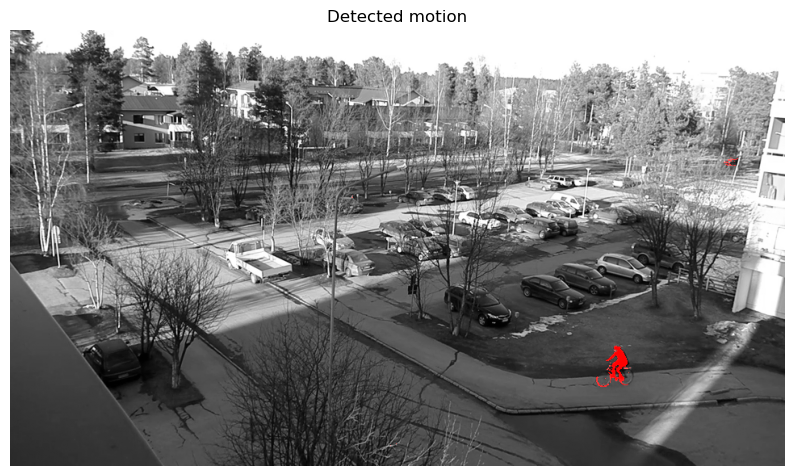

In [5]:
cap = cv2.VideoCapture('test.mp4')

N = 100
i = 0

state = state_initial.copy()

while i < N:

    ret, color = cap.read()
    if ret == False:
        break
        
    # Convert to grayscale
    frame = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)/255
    
    # Update
    state = updateBackgroundModel(frame, state);
    
    i += 1
     
cap.release()



# Threshold
thresh = thresholdFrame(frame, state);
#print(thresh)

#Overlay thresholded image on the frame
overlayed = np.stack((frame,)*3, axis=-1)
red = frame.copy()
red[thresh.astype(np.bool)] = 1
overlayed[:,:,0] = red

# Display
plt.figure(figsize=(10,7))
plt.imshow(overlayed)
plt.title('Detected motion')
plt.axis('off')
                       

**1.5. Improvements (optional)**

You can try different values of $\alpha$ (e.g. 0.8, 0.99, and 0.9999) and choose the most appropriate. You can also use morphological operations to remove spurious detections form the thresholded image. These operations can be added to `thresholdFrame` function. Feel free to explore any modifications to the given background subtraction algorithm to improve the result.

**1.6. Generate an output video (optional)**

Uncomment the following code cell to generate a short output video showing the detected regions.

In [6]:

cap = cv2.VideoCapture('test.mp4')

fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (width,height))

N = 200
i = 0

state = state_initial.copy()

while i < N:

    ret, color = cap.read()
    if ret == False:
        break

    # Convert to grayscale
    frame = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)/255
    
    # Threshold
    thresh = thresholdFrame(frame, state);
    
    # Update
    state = updateBackgroundModel(frame, state);
    
    # Write output frame
    red = color[:,:,2]
    red[thresh.astype(np.bool)] = 255
    color[:,:,2] = red
    out.write(color)
    
    i += 1
     
cap.release()
out.release()


C:\Users\Sicil\AppData\Local\Temp\ipykernel_53688\3472042572.py:31: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  red[thresh.astype(np.bool)] = 255


# References
[1] McKenna, S. J., Jabri, S., Duric, Z., Rosenfeld, A., & Wechsler, H. (2000). Tracking groups of people. Computer vision and image understanding, 80(1), 42-56.

[2] https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/